In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.lr"
snapshot_path = "."


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have no recurrent memory, it's okay to have short sessions... or is it not?
replay_seq_len = 5


In [2]:
#this is my machine-specific config. Comment out if you are not me.
%env THEANO_FLAGS='device=cpu'
snapshot_path = "/home/jheuristic/yozhik/agentnet_snapshots/"


env: THEANO_FLAGS='device=cpu'


# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments

* We take Space Invadets game as an example
* We train a simple-stupid convolutional network for Q_learning objective
* We do have a GPU for that, so if you don't, we have a "linear regression" mode - just uncomment it :)
* We train via experience replay using SessionPoolEnvironment, explained below
* We do NOT use recurrent layers for simplicity
* We do NOT use "smart" experience replay for simplicity
* We use simple stupid one-step q-learning.. you guessed it, for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
#Choose your side

#Sith
#mode = "simple convnet"

#Jedi
mode = "dense nn"

#Stormtrooper
#mode = "linear regression"


In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


In [5]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-04-29 01:26:13,757] Making new env: SpaceInvaders-v0


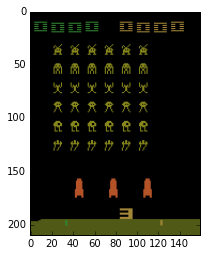

In [6]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

In [7]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [8]:
del atari

# agent setup
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * in this case, the resolver has epsilon-greedy policy
  
  
### Simple no-memory model

Since we have almost fully observable environment AND we want to keep baseline simple, we shall use NO agent memories and a simple lasagne CNN to process observations.



In [9]:
mode

'dense nn'

In [10]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [11]:
import lasagne

#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



#convolution
if mode == 'simple convnet':
    print "Using some CNNs"
    cnn = lasagne.layers.Conv2DLayer(observation_reshape,num_filters=32,filter_size=(5,5),name='cnn0')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool0')
    cnn = lasagne.layers.Conv2DLayer(cnn,num_filters=64,filter_size=(5,5),name='cnn1')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool1')
    nn = cnn
#dense with dropout
elif mode == "dense nn":
    print "Using simple dense network"
    
    dnn = lasagne.layers.DenseLayer(observation_reshape,num_units=500,name='dense0')
    dnn = lasagne.layers.DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = lasagne.layers.DenseLayer(dnn,num_units=500,name='dense1')
    nn = dnn

#linear regression
else:
    print "Using linear model"
    nn = observation_reshape




#memory

#no memory this time



#q_eval
q_eval = lasagne.layers.DenseLayer(nn,
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,
                                   name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



from collections import OrderedDict
#all together
agent = Agent(observation_layer,
              {},
              q_eval,resolver)


Using simple dense network


In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[dense0.W, dense0.b, dense1.W, dense1.b, QEvaluator.W, QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * to be covered where they are more useful
 

* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


# creating sessions

In [13]:
applier_observation = T.tensor4("input image",dtype=floatX)


res =agent.get_agent_reaction({},applier_observation)


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation],
        applier_actions)

In [14]:
#A whole lot of space invaders
ataries = [gym.make(GAME_TITLE) for i in range(N_PARALLEL_GAMES)]
for atari in ataries:
    atari.reset()

[2016-04-29 01:26:18,889] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:18,919] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:18,949] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:18,979] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,009] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,040] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,070] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,102] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,132] Making new env: SpaceInvaders-v0
[2016-04-29 01:26:19,162] Making new env: SpaceInvaders-v0


In [15]:
def interact(ataries,n_steps = 100):

    history_log = []
        
    prev_observations = map(lambda atari: atari.render('rgb_array'), ataries)
    
    
    
    for i in range(n_steps):
        
        actions = applier_fun(prev_observations)[0]
        
        new_observations, cur_rewards, is_done, infos = zip(*map(lambda atari, action: atari.step(action), 
                                                            ataries,actions))
        
        for i in range(len(ataries)):
            if is_done[i]:
                ataries[i].reset()
                print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,is_done))
        prev_observations = new_observations
                
    
    
    return zip(*history_log)
        
    
    
    
    
    

In [16]:
%%time
obsevation_log,action_log,reward_log,is_done_log  = interact(ataries,50)


print np.array(reward_log[:10]).T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['LEFT' 'RIGHTFIRE' 'LEFT' 'LEFT' 'RIGHTFIRE']
 ['LEFT' 'LEFT' 'NOOP' 'RIGHT' 'RIGHT']
 ['LEFTFIRE' 'LEFT' 'LEFT' 'LEFT' 'RIGHT']]
CPU times: user 7.32 s, sys: 240 ms, total: 7.56 s
Wall time: 7.56 s


# experience replay pool
### we shall use session pool environment to immediately train on new sessions
* theoretically, this environemnt is designed for storing a lot of game sessions and training on random batches,
* but for the sake of baseline, it's a one-time usage pool

1. Interact with ALE, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat

In [17]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [18]:
def update_pool(env, ataries,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    obsevation_log,action_log,reward_log,is_done_log= interact(ataries,n_steps=n_steps)
    
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(obsevation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [19]:
#load first  sessions
update_pool(env,ataries,replay_seq_len)

# Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [20]:
#produce interaction sequences of length <= 10

_,observation_seq,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)


#observation seq are the observation tensor we just loaded
#qvalues seq are agent's Qvalues obtained via experience replay


#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now

#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [21]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        action_seq,
                                                        rewards_seq,
                                                        is_alive_seq,
                                                        gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / is_alive_seq.sum()

In [22]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [23]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [24]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [25]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [26]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools

### [warning, this thing basicly tries to track various Qvalues over time]
### [but it's bulky and stupid, so don't try to understand it if it didn't come naturally]


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [27]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in ataries[:max_n_sessions]]
    
    if update:
        update_pool(env,ataries,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        qvalues_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(qvalues_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

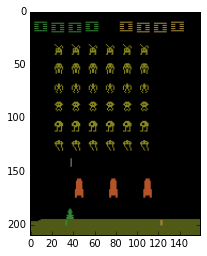

session # 0
 LEFT(qv = 0.0) -> 0.0 |  LEFT(qv = 58.8312416077) -> 0.0 |  LEFT(qv = 63.9313354492) -> 0.0 |  RIGHTFIRE(qv = 30.0715122223) -> 0.0 |  LEFT(qv = 60.8062210083) -> 0.0 | reached max session length


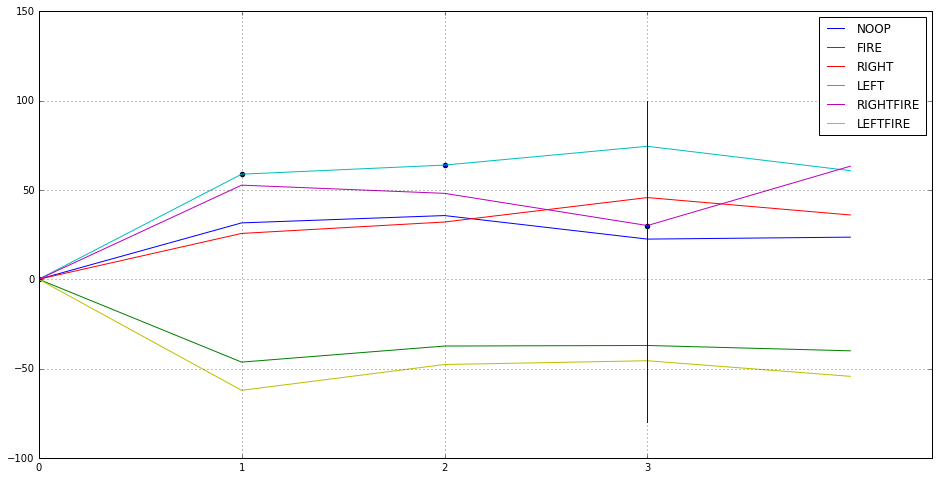

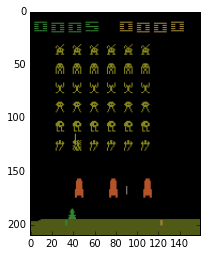

session # 0
 RIGHTFIRE(qv = 0.0) -> 0.0 |  LEFT(qv = 62.466583252) -> 0.0 |  LEFT(qv = 39.9121322632) -> 0.0 |  RIGHTFIRE(qv = 49.4169082642) -> 0.0 |  LEFT(qv = 47.5409011841) -> 0.0 | reached max session length


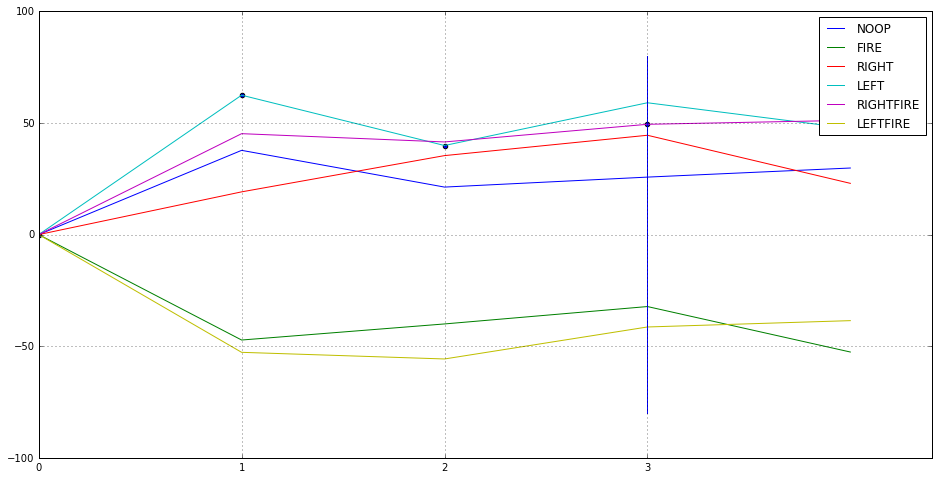

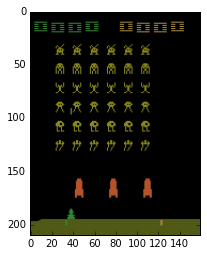

session # 0
 LEFT(qv = 0.0) -> 0.0 |  RIGHT(qv = 27.9379577637) -> 0.0 |  LEFT(qv = 56.7809906006) -> 0.0 |  LEFT(qv = 45.29347229) -> 0.0 |  LEFT(qv = 61.6401863098) -> 0.0 | reached max session length


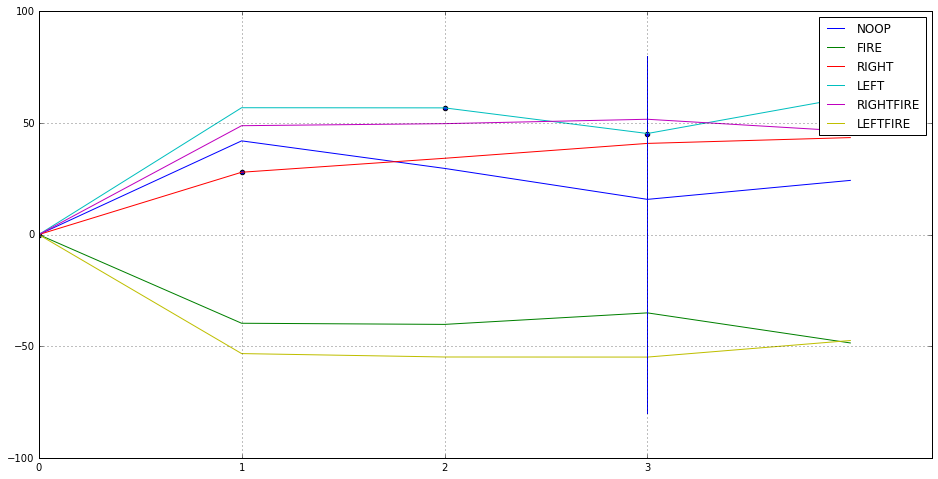

In [28]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [29]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [ ]:
n_epochs = 25000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,ataries,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,ataries,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,ataries,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %5000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

epoch 50,loss 520.20890, epsilon 0.45718, rewards: ( e-greedy 0.00000, greedy 0.00000) 
rec 520.058 reg 0.151
atari 9 reloaded
atari 5 reloaded
epoch 100,loss 174.00682, epsilon 0.41843, rewards: ( e-greedy 0.00000, greedy 0.25000) 
rec 173.856 reg 0.151
atari 2 reloaded
atari 0 reloaded
atari 6 reloaded
atari 4 reloaded
atari 1 reloaded
atari 7 reloaded
epoch 150,loss 119.87333, epsilon 0.38337, rewards: ( e-greedy 0.00000, greedy 0.22500) 
rec 119.723 reg 0.151
atari 2 reloaded
atari 9 reloaded
atari 5 reloaded
atari 3 reloaded
atari 8 reloaded
epoch 200,loss 530.50531, epsilon 0.35164, rewards: ( e-greedy 0.30000, greedy 0.20250) 
rec 530.355 reg 0.151
atari 1 reloaded
atari 0 reloaded
atari 4 reloaded
epoch 250,loss 32.11704, epsilon 0.32294, rewards: ( e-greedy 0.27000, greedy 0.28225) 
rec 31.966 reg 0.151
atari 9 reloaded
atari 5 reloaded
atari 6 reloaded
epoch 300,loss 19.23434, epsilon 0.29697, rewards: ( e-greedy 0.44300, greedy 0.25403) 
rec 19.084 reg 0.151
atari 1 reloaded

# Evaluating results

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
display_sessions(with_plots=True)


In [ ]:
def show(ataries,n_steps = 100):

    history_log = []
        
    prev_observations = map(lambda atari: atari.render('rgb_array'), ataries)
    
    
    
    for i in range(n_steps):
        
        #show pics
        map(lambda atari: atari.render('human'), ataries)

        
        actions = applier_fun(prev_observations)[0]
        
        new_observations, cur_rewards, is_done, infos = zip(*map(lambda atari, action: atari.step(action), 
                                                            ataries,actions))
        
        for i in range(len(ataries)):
            if is_done[i]:
                ataries[i].reset()
                print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,is_done))
        prev_observations = new_observations
                
    
    
    return zip(*history_log)
        
    
    
    
_=show(ataries[:1])
    